In [1]:
import numpy as np
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
ppdir = "/mnt/storage6/hemant/Memory-ANHA4-EPM111/timeseries/"

ds = xr.open_mfdataset(ppdir + "Ocean_temp*nc")
ds = ds.drop(['cell_area', 'nav_lat', 'nav_lon', 'vol_arctic', 'vol_subpolar_NAtl'])
ds = ds.sel(z=slice(0.,500.)).sum('z')

In [3]:
ds_clim = ds.groupby('time.month').mean('time')
ds = ds.groupby('time.month') - ds_clim

Text(0.5, 1.0, 'Sea ice area and volume')

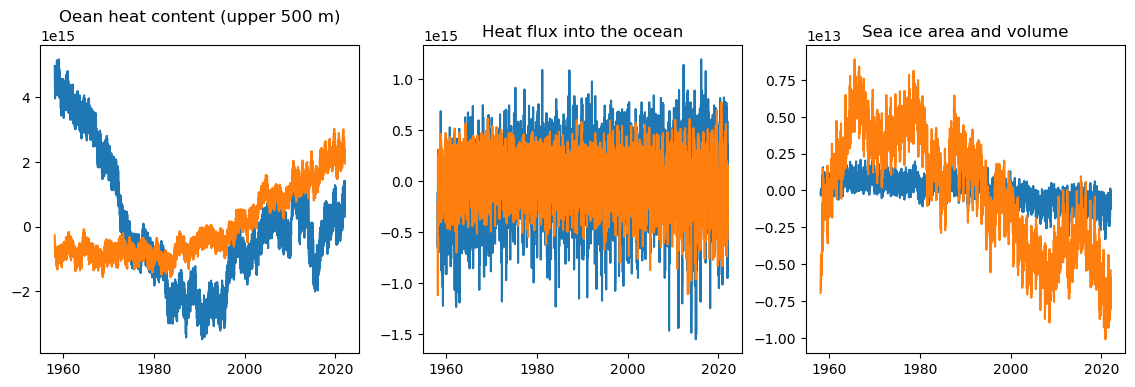

In [5]:
fig = plt.figure(figsize=[14,4])

tim = ds['time'].dt.year + ds['time'].dt.month / 12 + ds['time'].dt.day / 365.

plt.subplot(1,3,1)
plt.plot(tim, ds['votemper_subpolar_NAtl'])
plt.plot(tim, ds['votemper_arctic'])
plt.title('Oean heat content (upper 500 m)')

plt.subplot(1,3,2)
plt.plot(tim, ds['sohefldo_subpolar_NAtl'])
plt.plot(tim, ds['sohefldo_arctic'])
plt.title('Heat flux into the ocean')

plt.subplot(1,3,3)
plt.plot(tim, ds['ileadfra'])
plt.plot(tim, ds['ice_vol'])
plt.title('Sea ice area and volume')

In [24]:
# Reposne function

year_int = 30. # length of response function in years

tau_rng = np.arange(0.5, 20.1, 1.5)
beta_rng = np.arange(0.0, 10.1, 2.0)

# temporary timeseries for getting the response function right
tim = ds['time'].dt.year + ds['time'].dt.month / 12 + ds['time'].dt.day / 365. - ds['time.year'].values[0] - 10.
fac = int(365./5.)

Response_function_full = []
for tau in tau_rng:
    
    # loop for testing beta for sinusodial damping 
    Response_function_tau = []
            
    for beta in beta_rng:
    
        # Response function for Sinusoidal Damping term
        Response_function1 = np.exp(-(tim) / (tau)) * ( np.cos(tim * beta / tau))
        Response_function1 = xr.where(tim < 0., 0., Response_function1)
        Response_function1 = xr.where((tim > 1.5 * np.pi * tau/beta), 0., Response_function1)
            
        Response_function1 = Response_function1.isel(time=slice(10*fac - 1, 10*fac-1 + int(fac*year_int)))
        Response_function1 = Response_function1.isel(time=slice(None, None, -1)).drop('time')
    
        Response_function_tau.append(Response_function1)
    
    Response_function_tau = xr.concat(Response_function_tau, dim="beta")
    
    Response_function_full.append(Response_function_tau)
    
Response_function_full = xr.concat(Response_function_full, dim="tau")

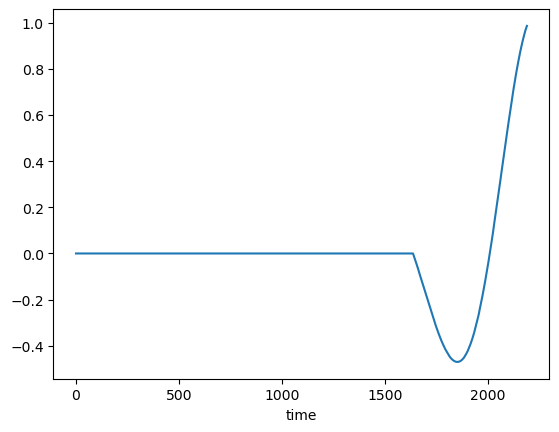

In [25]:
Response_function_full.isel(tau=4, beta=2).plot()

In [28]:
Pred_arctic = xr.zeros_like(ds['sohefldo_arctic'])
Pred_arctic = Pred_arctic / Pred_arctic

(tmp, Pred_arctic) = xr.broadcast(Response_function_full.isel(time=0), Pred_arctic)

Pred_arctic = Pred_arctic.copy() # otherwise runs into "assignment destination is read-only" error
Pred_subpolar_Atl = Pred_arctic.copy()

In [32]:
ds

<xarray.Dataset>
Dimensions:                 (time: 4672, y: 520, x: 544)
Coordinates:
    time_centered           (time) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time                    (time) object 1958-01-03 12:00:00 ... 2021-12-29 ...
    lat                     (y, x) float32 dask.array<chunksize=(520, 544), meta=np.ndarray>
    lon                     (y, x) float32 dask.array<chunksize=(520, 544), meta=np.ndarray>
    month                   (time) int64 1 1 1 1 1 1 2 ... 11 12 12 12 12 12 12
Dimensions without coordinates: y, x
Data variables:
    votemper_subpolar_NAtl  (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    votemper_arctic         (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    ice_vol                 (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    ileadfra                (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    sohefldo_subpolar_NAtl  (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    sohefldo_arctic         (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>

## Check final output

In [2]:
ds = xr.open_dataset("/mnt/storage6/hemant/Memory-ANHA4-EPM111/Recons_green_function/Response_heat_flux.nc")

print(ds)

<xarray.Dataset>
Dimensions:                 (time: 4672, gamma: 40, beta: 21, y: 520, x: 544)
Coordinates:
    time_centered           (time) object ...
  * time                    (time) object 1958-01-03 12:00:00 ... 2021-12-29 ...
    lat                     (y, x) float32 ...
    lon                     (y, x) float32 ...
    month                   (time) int64 ...
  * gamma                   (gamma) float64 0.5 1.0 1.5 2.0 ... 19.0 19.5 20.0
  * beta                    (beta) float64 0.0 0.5 1.0 1.5 ... 8.5 9.0 9.5 10.0
Dimensions without coordinates: y, x
Data variables:
    votemper_subpolar_NAtl  (time) float32 ...
    votemper_arctic         (time) float32 ...
    ice_vol                 (time) float32 ...
    ileadfra                (time) float32 ...
    sohefldo_subpolar_NAtl  (time) float32 ...
    sohefldo_arctic         (time) float32 ...
    Pred_arctic             (gamma, beta, time) float32 ...
    Pred_subpolar_Atl       (gamma, beta, time) float32 ...


Text(0.5, 1.0, 'Prections from heat flux')

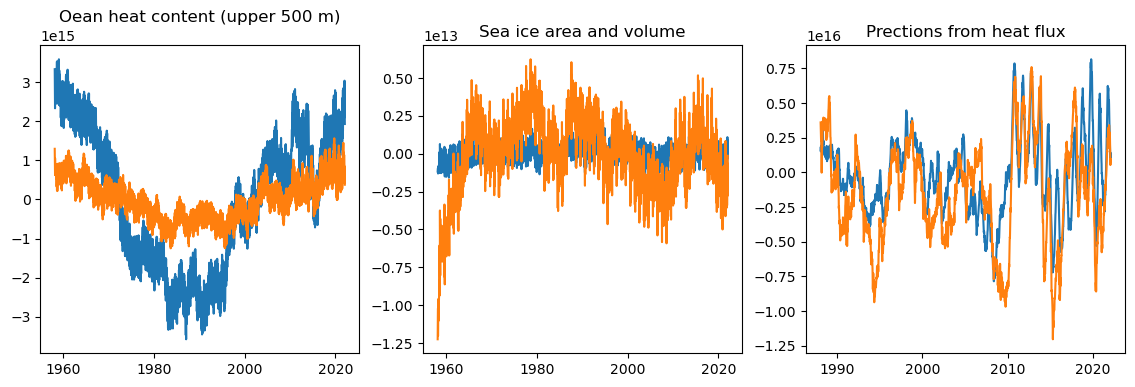

In [6]:
fig = plt.figure(figsize=[14,4])

tim = ds['time'].dt.year + ds['time'].dt.month / 12 + ds['time'].dt.day / 365.

plt.subplot(1,3,1)
plt.plot(tim, ds['votemper_subpolar_NAtl'])
plt.plot(tim, ds['votemper_arctic'])
plt.title('Oean heat content (upper 500 m)')

plt.subplot(1,3,2)
plt.plot(tim, ds['ileadfra'])
plt.plot(tim, ds['ice_vol'])
plt.title('Sea ice area and volume')

plt.subplot(1,3,3)
plt.plot(tim, ds['Pred_arctic'].sel(gamma = 6., beta = 3.))
plt.plot(tim, ds['Pred_subpolar_Atl'].sel(gamma = 6., beta = 3.))
plt.title('Prections from heat flux')